<a href="https://colab.research.google.com/github/krumeto/own_work/blob/master/Patient_readmission_based_on_Diabetes_data_from_130_US_hospitals_for_years_1999_2008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [0]:
#SciKit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Patient readmission prediction based on Diabetes data from 130 US hospitals for years 1999-2008

### Autor: Krum Arnaudov for Machine Learning course, October 2018, SoftUni

This study used the Health Facts database (Cerner Corporation, Kansas City, MO), a national data warehouse that collects comprehensive clinical records across hospitals throughout the United States. The dataset was found in and provided by Kaggle, but very few Kernels have used it so far. 

The data set represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

* It is an inpatient encounter (a hospital admission).
* It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
* The length of stay was at least 1 day and at most 14 days.
* Laboratory tests were performed during the encounter.
* Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

The Feature Description file contains information on all features of the dataset.

The goal of the study is to model readmission paterns. Due to time constraint, I will use binary classification - "readmitted" or "not". 

## **1. Exploratory Data Analysis and Preprocessing**

In [0]:
data = pd.read_csv("diabetic_data.csv")

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71967 entries, 0 to 71966
Data columns (total 50 columns):
encounter_id                71967 non-null int64
patient_nbr                 71967 non-null int64
race                        71967 non-null object
gender                      71967 non-null object
age                         71967 non-null object
weight                      71967 non-null object
admission_type_id           71967 non-null int64
discharge_disposition_id    71967 non-null int64
admission_source_id         71967 non-null int64
time_in_hospital            71967 non-null int64
payer_code                  71967 non-null object
medical_specialty           71967 non-null object
num_lab_procedures          71967 non-null int64
num_procedures              71967 non-null int64
num_medications             71967 non-null int64
number_outpatient           71967 non-null int64
number_emergency            71967 non-null int64
number_inpatient            71967 non-null int64
dia

The dataset contains 50 columns and 101765 rows. Suprisingly, it looks like having no missing values. This looks highly suspicious, considering the fact that should-be-numerical columns like 'age' and 'weight' are read as objects. Let us take a closer look at the first rows of data.

In [0]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Looking at the weight column, it looks like missing values were mapped with question marks in the dataset. Let us look if that same pattern can be seen in other columns

In [0]:
mask = data.applymap(lambda x: '?' in str(x)) ##https://stackoverflow.com/questions/44237170/how-to-search-a-partial-string-in-the-whole-dataframe-using-pandas
#na_data = data[mask.any(axis=1)]
#na_data
mask.sum()

encounter_id                    0
patient_nbr                     0
race                         1377
gender                          0
age                             0
weight                      69596
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  37165
medical_specialty           30018
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         18
diag_2                        316
diag_3                       1250
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

High number of NaNs can be observed in columns weight (above 90%), payer code and medical specialty. I will replace the question mark with NaN to enable Pandas NaN-related functions.

In [0]:
data = data.replace('?', np.nan)
data.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         1377
gender                          0
age                             0
weight                      69596
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  37165
medical_specialty           30018
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         18
diag_2                        316
diag_3                       1250
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [0]:
data.payer_code.unique()

array([nan, 'MC', 'MD', 'HM', 'UN', 'BC', 'SP', 'CP', 'SI', 'DM', 'CM',
       'CH', 'PO', 'WC', 'OT', 'OG', 'MP'], dtype=object)

I will choose to remove Payer Code from the dataset - it identifies ensurance companies paying. In addition to having many NaNs, I believe that it will not have significant effect on readmission. Column Weight will be dropped due to having very few lines of data.

In [0]:
data.drop(columns=['payer_code', 'weight'], axis=1, inplace=True) #Removing Weight as the vast majority of the data is missing, removing Payer_code as irrelevant

Next decision to make is if the specialty of the admitting physician (column medical_specialty) should be retain. To enable a more informed decision, I will visualize the data.

In [0]:
data.medical_specialty = data.medical_specialty.replace(np.nan, "missing")

In [0]:
data.groupby('medical_specialty').size().sort_values(ascending=False)

medical_specialty
missing                                 30018
InternalMedicine                        12910
Family/GeneralPractice                   6605
Cardiology                               4571
Emergency/Trauma                         4176
Surgery-General                          2373
Nephrology                               1475
Orthopedics-Reconstructive               1172
Orthopedics                               996
Pulmonology                               775
Psychiatry                                765
Surgery-Cardiovascular/Thoracic           618
Urology                                   603
ObstetricsandGynecology                   590
Surgery-Neuro                             454
Gastroenterology                          448
Surgery-Vascular                          444
Radiologist                               389
PhysicalMedicineandRehabilitation         386
Oncology                                  320
Pediatrics                                229
Hematology/Oncol

In [0]:
print("Percentage of the top 10 medical specialty categories from all: {}".format(data.groupby('medical_specialty').size().sort_values(ascending=False).head(10).sum()*100/data.shape[0]))


Percentage of the top 10 medical specialty categories from all: 90.41783039448636


The top 10 categories, including "missing" account for 91.8% of all data points, while 63 other unique categories contribute to less than 9%. I addition, many of the labels are overlapping - Cardiology (5th biggest) is a main specialty in the Internal Medicine (2nd biggest); there are multiple Pediatrics labels.

With all said above, I will drop the column from the further dataset.

In [0]:
data.drop(columns=['medical_specialty'], axis=1, inplace=True)

Last NaN decision to be made is in relation to the small number of NaNs in the Diagnosis and Race columns. Before deleting any rows, I would like to make sure those are distributed homoscedastically in relation to Readdmited. To do this, I will look at the distribution of the target variable (readmitted) for the whole dataset and compare it to the rows with missing info.

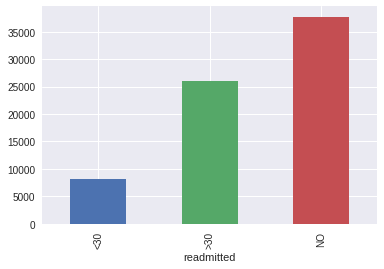

In [0]:
data.groupby('readmitted').size().plot(kind='bar')
plt.show()

In [0]:
nan_data = data.loc[data.race.isnull()|data.diag_1.isnull()|data.diag_2.isnull()|data.diag_3.isnull()]

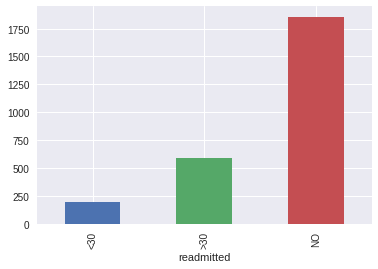

In [0]:
nan_data.groupby('readmitted').size().plot(kind='bar')

The target variable in the rows of data containing NaNs is distibuted very similarly to the rest of the dateset. I will remove the rows with NaN from the dataset.

In [0]:
data.dropna(axis=0, inplace=True)

In [0]:
print("Dimension of the Diabetes data after NaN removal: {}".format(data.shape))

Dimension of the Diabetes data after NaN removal: (69324, 47)


Continuing with the preprocessing of the data, there are several variables that were read as numerical, while in fact we need them as categorical (information on variable description can be found in the Feature Description file. Let us transform them accordingly.

In [0]:
data.admission_type_id = data.admission_type_id.astype(object)
data.discharge_disposition_id = data.discharge_disposition_id.astype(object)
data.admission_source_id = data.admission_source_id.astype(object)
data.encounter_id = data.encounter_id.astype(object)
data.patient_nbr = data.patient_nbr.astype(object)

Encounter ID is a unique identifier, so I will change the table index to it.

In [0]:
data = data.set_index('encounter_id')

"Age" is currently a categorical variable, noted in range-like format - for example, [10-20) . I believe transfering it to numerical would make sense - we can then scale it appropriately.

In [0]:
def range_to_mean(string_range):
    """
    Simple function that takes a string nummeric range and outputs its mean
    """
    np_range = np.array(re.findall('\d+', string_range))
    np_range = np.asfarray(np_range,float)
    
    return np_range.mean()

In [0]:
data.age = data.age.apply(range_to_mean)

##### Scaling of numerical features

As a next step I will scale the numerical features using sklearn MinMaxScale and save it as a separate dataframe.

In [0]:
def numeric_col_scaler(df, col):
    scaler = MinMaxScaler()
    to_be_scaled = df[col].values.reshape(-1,1)
    return scaler.fit_transform(to_be_scaled)

In [0]:
data_scaled = data.copy()
for col in data_scaled.select_dtypes(include=[np.number]).columns:
    data_scaled[col] = numeric_col_scaler(data_scaled, col)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# Considering the number of columns, it is easier to eyeball the data when transposed
data_scaled.T

encounter_id,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236,...,209516268,209529030,209532582,209538426,209540772,209547540,209552634,209556540,209558724,209562162
patient_nbr,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032,...,44132427,107912718,84457323,91080846,113373018,103065471,94101516,100482156,52714017,70076169
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,...,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female,...,Male,Male,Male,Male,Female,Female,Female,Female,Female,Male
age,0.111111,0.222222,0.333333,0.444444,0.555556,0.666667,0.777778,0.888889,1,0.444444,...,0.666667,0.777778,0.666667,0.555556,0.777778,0.888889,0.888889,0.888889,0.777778,0.888889
admission_type_id,1,1,1,1,2,3,1,2,3,1,...,3,3,2,2,1,2,3,1,1,2
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1,...,1,3,1,6,1,3,1,3,3,1
admission_source_id,7,7,7,7,2,2,7,4,4,7,...,1,7,1,4,7,7,1,7,7,1
time_in_hospital,0.153846,0.0769231,0.0769231,0,0.153846,0.230769,0.307692,0.923077,0.846154,0.615385,...,0,0.846154,0.307692,0.461538,0,0.153846,0.0769231,0.230769,0.923077,0.230769
num_lab_procedures,0.453125,0.078125,0.335938,0.390625,0.234375,0.539062,0.5625,0.523438,0.25,0.359375,...,0.242188,0.601562,0.390625,0.234375,0.34375,0.445312,0.1875,0.453125,0.46875,0.546875
num_procedures,0,0.833333,0.166667,0,1,0.166667,0,0.333333,0.5,0.333333,...,1,1,0.666667,0.166667,0,0.166667,0.166667,0.166667,0.166667,0


The data is looking good - all numerical features are now scaled between 0 and 1. Next step would be to take a look at the categorical features and create dummies. First, let us get a look at the possible added dimensions.

##### Dummy values creation

In [0]:
categorical_columns = data_scaled.select_dtypes(exclude=[np.number]).columns
categorical_columns = categorical_columns.drop(['patient_nbr', 'readmitted'])
for col in categorical_columns:
    print(str(col) + ": " + str(len(data_scaled[col].unique())))

race: 5
gender: 3
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 14
diag_1: 686
diag_2: 687
diag_3: 721
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
acetohexamide: 2
glipizide: 4
glyburide: 4
tolbutamide: 2
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
troglitazone: 2
tolazamide: 3
examide: 1
citoglipton: 1
insulin: 4
glyburide-metformin: 4
glipizide-metformin: 2
glimepiride-pioglitazone: 1
metformin-rosiglitazone: 1
metformin-pioglitazone: 1
change: 2
diabetesMed: 2


The 3 Diagnosis would add 2100+ dimentions alone. Going back to the feature definition, diag_1 is the primary diagnosis, while diag_2 and diag_3 are the secondary ones. For simplicity, I will drop diag_2 and diag_3 before creating dummy features and proceed with dummy creation for the categorical columns.

In [0]:
data_scaled.drop(columns=['diag_2', 'diag_3'], axis=1, inplace=True)

In [0]:
categorical_columns = data_scaled.select_dtypes(exclude=[np.number]).columns
categorical_columns = categorical_columns.drop(['patient_nbr', 'readmitted']) # Removing the target value and patient numbers
data_scaled_dummied = pd.get_dummies(data_scaled, columns=categorical_columns, prefix=categorical_columns)

In [0]:
print("Dimension of the data after scaling and dummy creation: {}".format(data_scaled_dummied.shape))

Dimension of the data after scaling and dummy creation: (69324, 833)


## **2. Model training, comparisson and fine-tuning**

Due to time restrictions, I will only focus on binary clasification and will transform the target value accordingly.

In [0]:
binary_target = data_scaled_dummied.readmitted.replace({'>30': 1, '<30': 1, 'NO': 0})

In [0]:
features = data_scaled_dummied.drop(['readmitted', "patient_nbr"], axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, binary_target, stratify=binary_target, train_size = 0.75, test_size = 0.25)


In [0]:
print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(51993,) (17331,)
(51993, 831) (17331, 831)


#### **2.1. Modeling**

#### **Logistic Regression**
I will start with the classics for classification - Logistic Regression. Due to the sheer number of columns, I will use penalty L1 - LASSO to reduce the effect of the high number of data dimensions.

In [0]:
grid={"C":[0.01, 0.1, 1, 10, 100]}
logreg=LogisticRegression(penalty = "l1")# l1 lasso
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

KeyboardInterrupt: ignored

In [0]:
#Saving the model and parameters
logreg=LogisticRegression(penalty = "l1", C=1).fit(X_train,y_train)

#### **Decision Tree Classifier**
Next model to add is Decision Tree Classifier. In addition to its simplicity, it will allow me to gain some insight into the most important features.

In [0]:
tuned_params = [{"max_depth": [1,  7, 15], "min_samples_leaf": [2, 3,5], "max_leaf_nodes": [10, 20, 30]}]
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tuned_params, cv=5)
tree_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",tree_grid_search.best_params_)
print("accuracy :",tree_grid_search.best_score_)

tuned hyperparameters :(best parameters)  {'max_depth': 15, 'max_leaf_nodes': 30, 'min_samples_leaf': 2}
accuracy : 0.6293667305783326


In [0]:
tree = DecisionTreeClassifier(max_depth= 15, max_leaf_nodes =  30, min_samples_leaf =2).fit(X_train,y_train)

#### **Support Vector Machines**
Next model to add is Linear SVC. Similarly to the Logistic Regression, I will use L1 penalty to handle the high number of dimensions.

In [0]:
tuned_params =  [{"C": [0.01, 0.05, 0.1, 1]}]
svc_grid_search = GridSearchCV(LinearSVC(penalty="l1", dual=False), tuned_params, cv=5)
svc_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",svc_grid_search.best_params_)
print("accuracy :",svc_grid_search.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1}
accuracy : 0.6354995308611757


In [0]:
linear_svc = LinearSVC(penalty="l1", dual=False, C=0.1).fit(X_train,y_train)

#### **Gradient Boosting**
Hm, results seem a bit underwhelming. I will add an ensamble to the models, hoping for an improvement. Gradient Boosting is a

In [0]:
boosted_ensemble = GradientBoostingClassifier()

tuned_params = [{"n_estimators":[10, 50,100,150, 200], "max_depth": [1, 5, 7, 15], "min_samples_leaf": [1, 2, 5, 10, 12]}]
boosted_grid_search = GridSearchCV(boosted_ensemble, tuned_params, cv=5)
boosted_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",boosted_grid_search.best_params_)
print("accuracy :",boosted_grid_search.best_score_)

The results so far have been rather underwhelming. One reason can be the relatively high number of dimensions. We can reduce the dimensions (Dimensionality Reduction) or select the most influencial features (Feature Selection). Starting with Principal Component Analysis (PCA) we can gain insight for further actions. PCA is a dimensionality reduction technique but it can also help us find out the components with maximum variance.

In [0]:
pca = PCA(n_components=863)
pca.fit(features)

Calculating and plotting Eigenvalues

In [0]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

In [0]:
plt.plot(var)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
#plt.style.context('seaborn-whitegrid')

plt.show()

In [0]:


feature_selector = SelectKBest(chi2, k=120)
feature_selector.fit(features, binary_target)
#features_new = SelectKBest(chi2, k=120).fit_transform(features, binary_target)

In [0]:
print(len(feature_selector.get_support()))



In [0]:
cols = [features.columns[i] for i in range(863) if feature_selector.get_support()[i]==True]
cols

In [0]:
features_after_selection = features[cols]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features_after_selection, binary_target, stratify=binary_target, train_size = 0.7, test_size = 0.3)

In [0]:
logreg_basic = LogisticRegression(penalty='l1', C=2).fit(features_after_selection, binary_target)
print("Training set accuracy: {:.3f}".format(logreg_basic.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg_basic.score(X_test, y_test)))

In [0]:
boosted_ensemble = GradientBoostingClassifier(n_estimators=200)
boosted_ensemble.fit(features_after_selection, binary_target)
print("Accuracy on training set: {:.3f}".format(boosted_ensemble.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(boosted_ensemble.score(X_test, y_test)))

In [0]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

In [0]:
tuned_params =  [{"C": [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20]}]
svc_grid_search = GridSearchCV(LinearSVC(), tuned_params, cv=5)
svc_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",svc_grid_search.best_params_)
print("accuracy :",svc_grid_search.best_score_)


In [0]:
tuned_params =  [{"C": [0.01, 0.05, 0.1, 1]}]
svc_grid_search = GridSearchCV(LinearSVC(penalty="l1", dual=False), tuned_params, cv=5)
svc_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",svc_grid_search.best_params_)
print("accuracy :",svc_grid_search.best_score_)

In [0]:
tuned_params = [{"max_depth": [1, 5, 7, 15, 20], "min_samples_leaf": [2, 5, 10, 12], "max_leaf_nodes": [5, 10, 20]}]
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tuned_params, cv=5)
tree_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",tree_grid_search.best_params_)
print("accuracy :",tree_grid_search.best_score_)

!!!!!!!!!!!!In the above array we see that the first feature explains 9.6% of the variance within our data set while the first two explain 17.8% and so on. If we employ all features we capture 100% of the variance within the dataset, thus we gain some by implementing an additional feature. No any single feature outstanding

In [0]:
logreg_basic = LogisticRegression(penalty='l1').fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg_basic.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg_basic.score(X_test, y_test)))

In [0]:
y_pred_log = logreg_basic.predict(X_test)
y_pred_tree = tree.predict(X_test)
y_pred_boost = boosted_ensemble.predict(X_test)
from sklearn.metrics import roc_curve, auc
log_false_positive_rate, log_true_positive_rate, log_thresholds = roc_curve(y_test, y_pred_log)
log_roc_auc = auc(log_false_positive_rate, log_true_positive_rate)
print(log_roc_auc)
tree_false_positive_rate, tree_true_positive_rate, tree_thresholds = roc_curve(y_test, y_pred_tree)
tree_roc_auc = auc(tree_false_positive_rate, tree_true_positive_rate)
print(tree_roc_auc)
boost_false_positive_rate, boost_true_positive_rate, boost_thresholds = roc_curve(y_test, y_pred_boost)
boost_roc_auc = auc(boost_false_positive_rate, boost_true_positive_rate)
print(boost_roc_auc)

In [0]:
print(metrics.confusion_matrix(y_test, logreg_basic.predict(X_test)))

In [0]:
print(metrics.confusion_matrix(y_test, boosted_ensemble.predict(X_test)))

In [0]:
print(metrics.confusion_matrix(y_test, tree.predict(X_test)))

Basic terminology

True Positives (TP): we correctly predicted that they do have diabetes
15
True Negatives (TN): we correctly predicted that they don't have diabetes
118
False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")
12
Falsely predict positive
Type I error
False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")
47
Falsely predict negative
Type II error

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg_basic.predict(X_test))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [0]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [0]:
evaluate_threshold(0.5)

In [0]:
evaluate_threshold(0.9)

In [0]:
tree = DecisionTreeClassifier(max_depth= 7, max_leaf_nodes =  20, min_samples_leaf =2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

In [0]:
boosted_ensemble = GradientBoostingClassifier(n_estimators=200)
boosted_ensemble.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(boosted_ensemble.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(boosted_ensemble.score(X_test, y_test)))

In [0]:
boosted_ensemble = GradientBoostingClassifier()

tuned_params = [{"n_estimators":[10, 50,100,150, 200], "max_depth": [1, 5, 7, 15], "min_samples_leaf": [1, 2, 5, 10, 12]}]
boosted_grid_search = GridSearchCV(boosted_ensemble, tuned_params, cv=5)
boosted_grid_search.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",boosted_grid_search.best_params_)
print("accuracy :",boosted_grid_search.best_score_)

In [0]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca_120 = PCA(n_components=120)

In [0]:
pca_120.fit(X_train)

In [0]:
train_img = pca_120.transform(X_train)
test_img = pca_120.transform(X_test)

In [0]:

logreg_pca = LogisticRegression(C=0.01).fit(train_img, y_train)
print("Training set accuracy: {:.3f}".format(logreg_pca.score(train_img, y_train)))
print("Test set accuracy: {:.3f}".format(logreg_pca.score(test_img, y_test)))

In [0]:
lin_svc = LinearSVC().fit(train_img, y_train)
print("Training set accuracy: {:.3f}".format(lin_svc.score(train_img, y_train)))
print("Test set accuracy: {:.3f}".format(lin_svc.score(test_img, y_test)))

In [0]:
lin_svc_without_pca = LinearSVC().fit(train_img, y_train)

print("Training set accuracy: {:.3f}".format(lin_svc_without_pca.score(train_img, y_train)))
print("Test set accuracy: {:.3f}".format(lin_svc_without_pca.score(test_img, y_test)))

To Do list:
* Repeat the GridSearch with scoring F1
* Repeat with not removing the Medical Specialty
* Transform some of the sorted categoricals into numerical values

## References

1) https://www.kaggle.com/brandao/diabetes/home <br />
2) 2014 Beata Strack et al.Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records <br />
3) https://medium.com/analytics-vidhya/scikit-learn-a-silver-bullet-for-basic-machine-learning-13c7d8b248ee <br />
4) https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Machine%20Learning%20for%20Diabetes.ipynb <br />
5) https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 <br />
6) https://towardsdatascience.com/predicting-hotel-bookings-with-user-search-parameters-8c570ab24805 <br />
7) https://www.kaggle.com/dkim1992/feature-selection-ranking <br />
8) https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae <br />
9) https://www.ritchieng.com/machine-learning-evaluate-classification-model/ <br />
10) Countless StackOverflow articles <br />
11) SKLearn Documentation and User Guide <br />